In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from time import time

# 1. Data extraction

In [ ]:
%%time
# read all files
directory=r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\maildir'

subset=os.listdir(directory)

msg_id= list()
msg_txt= list()

for folder in subset:
    for roots, dirs, files in os.walk(directory+"\\"+folder):
        for file in files:
            with open(roots+'\\'+file) as f:
                x= f.readlines()
                x=''.join(x)
                msg_txt.append(x)
                msg_id.append(roots[roots.index(folder):] + '\\'+file)

In [ ]:
data=pd.DataFrame(zip(msg_id,msg_txt),columns=['message_id','message_text'])
data.to_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\emails.csv',index=False)

# 2. Email elements extraction

In [ ]:
data= pd.read_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\emails.csv')

In [ ]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = list(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [ ]:
%%time
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, data['message_text']))
data.drop(columns=['message_text'], inplace=True)

# Get fields from parsed email objects
#keys = messages[0].keys()
keys=['Message-ID', 'Date', 'From', 'To', 'Subject', 'Cc', 'Bcc','X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName']

for key in keys:
    data[key] = [doc[key] for doc in messages]
    
# Parse content from emails
data['body'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
data['From'] = data['From'].map(split_email_addresses)
data['To']   = data['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
data['user'] = data['message_id'].map(lambda x:x.split('/')[0])
del messages

data.head(1)

In [ ]:
df=data[['message_id','Date','From','To','Subject','Cc','Bcc','body']]
df=df.rename(columns={"Date": "date", "From": "from",'To':'to','Subject':'subject','Cc':'cc','Bcc':'bcc'})
df.to_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\complete data.csv',index=False)

# 2.  Duplicate elimination, HTML extractor and Thread split

## Remove duplicates

In [3]:
data= pd.read_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\complete data.csv')
data.head()

,message_id,date,from,to,subject,cc,bcc,body
0,allen-p\all_documents\1,"Wed, 13 Dec 2000 18:41:00 -0800 (PST)",['1.11913372.-2@multexinvestornetwork.com'],['pallen@enron.com'],"December 14, 2000 - Bear Stearns' predictions ...",NaN,NaN,In today's Daily Update you'll find free repor...
1,allen-p\all_documents\10,"Wed, 13 Dec 2000 08:35:00 -0800 (PST)",['messenger@ecm.bloomberg.com'],NaN,Bloomberg Power Lines Report,NaN,NaN,Here is today's copy of Bloomberg Power Lines....
2,allen-p\all_documents\100,"Mon, 9 Oct 2000 07:16:00 -0700 (PDT)",['phillip.allen@enron.com'],['keith.holst@enron.com'],Consolidated positions: Issues & To Do list,NaN,NaN,---------------------- Forwarded by Phillip K ...
3,allen-p\all_documents\101,"Mon, 9 Oct 2000 07:00:00 -0700 (PDT)",['phillip.allen@enron.com'],['keith.holst@enron.com'],Consolidated positions: Issues & To Do list,NaN,NaN,---------------------- Forwarded by Phillip K ...
4,allen-p\all_documents\102,"Thu, 5 Oct 2000 06:26:00 -0700 (PDT)",['phillip.allen@enron.com'],['david.delainey@enron.com'],NaN,NaN,NaN,"Dave, \n\n Here are the names of the west desk..."


In [4]:
# We are interested only on subject and body
data.drop(['date','from','to','cc','bcc'],axis=1,inplace=True)

In [5]:
data.drop_duplicates(['subject', 'body'],inplace=True)

## HTML cleaning

In [6]:
def parse_html(text):
    pattern = "<html>(.+?)</html>"
    if re.search(pattern, text, re.IGNORECASE + re.DOTALL):
        soup = BeautifulSoup(text, 'html5')
        for data in soup(['style']):
              data.decompose()
        soup = BeautifulSoup(soup.get_text(), 'html5')
        return soup.get_text()
    else:
        return text

In [7]:
# Removing htmls
data['body_html'] = data['body'].map(parse_html)

## Thread splitting

In [8]:
# Suppose no lower case To From Subject
def chain_split(a, subject):
    # print(a)
    text = a
    a = a.split('\n')
    end = []
    start = []
    subs = []
    i = 0
    if_chain = False
    while i < len(a):
        if re.search(re.compile(r'forwarded by|original message|--original', re.IGNORECASE),a[i]):
            start.append(i)
        elif len(start)==len(end) and re.search(r'From:',a[i]):
            start.append(i)
        elif len(start)==len(end) and re.search(r'To:',a[i]):
            start.append(i-3)
        elif re.search(r'Subject:',a[i]):
            s = i
            if len(end)==len(start):
                if len(start)!=0:
                    subs[-1] = s
                    end[-1] = i
            else:
                subs.append(s)
                end.append(i)
        i+=1

    if len(start)>len(end):
        start = start[:len(end)]

    emails = []
    subjects = []
    pre = 0
    subjects.append(subject)
    for sub in subs: 
        subjects.append(a[sub].split('Subject:')[-1].strip('\t'))
    for s, e in zip(start, end):
        if pre != s:
            emails.append("\n".join(a[pre:s]).strip('\n'))
        else:
            emails.append(" ")
        pre = e+1
        for i in range(s, e+1):
            a[i] = ""
    if pre < len(a):
        emails.append("\n".join(a[pre:]).strip('\n'))
    else:
        emails.append(" ")

    combine = [(len(emails)-i, sub, email) for i, (sub, email) in enumerate(zip(subjects, emails))]
    combine.reverse()
    a = "\n".join(a)
    return len(start), combine

In [9]:
data['new_body'] = data.apply(lambda x:chain_split(x['body_html'],x['subject']), axis=1)

In [10]:
data['chain_len'] = data['new_body'].map(lambda x:x[0])
data['subjects_emails'] = data['new_body'].map(lambda x:x[1])

In [11]:
df_new = data[['message_id','subjects_emails']].explode('subjects_emails')

In [12]:
df_new.reset_index(inplace = True)
df_new.drop(["index"], axis= 1, inplace = True)
# df_new = df_new[df_new['subjects_emails'].notna()]
df_new['idx'] = df_new['subjects_emails'].map(lambda x:x[0])
df_new['subject'] = df_new['subjects_emails'].map(lambda x:x[1])
df_new['email'] = df_new['subjects_emails'].map(lambda x:x[2])
# df_new = df_new[(df_new['email']!=' ') & (df_new['subject']!=' ')]
df_new['email_id'] = df_new.apply(lambda x: x['message_id']+'#'+str(x['idx']), axis = 1)
df_new = df_new[["email_id", "subject", "email"]]
df_new 

,email_id,subject,email
0,allen-p\all_documents\1#1,"December 14, 2000 - Bear Stearns' predictions ...",In today's Daily Update you'll find free repor...
1,allen-p\all_documents\10#1,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....
2,allen-p\all_documents\100#1,Consolidated positions: Issues & To Do list,From our initial set of meetings with the trad...
3,allen-p\all_documents\100#2,Consolidated positions: Issues & To Do list,"Phillip,\n Below is the issues & to do list as..."
4,allen-p\all_documents\100#3,Consolidated positions: Issues & To Do list,
...,...,...,...
466893,zufferli-j\sent_items\98#1,Calgary Analyst/Associate,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...
466894,zufferli-j\sent_items\99#1,ali's essays,Hi John\n\n How was Thanksgiving? Was th...
466895,zufferli-j\sent_items\99#2,RE: ali's essays,01:41 PM\n\n\n\n\n\n\njust...
466896,zufferli-j\sent_items\99#3,RE: ali's essays,i don't know about the heart classes. i'll lo...


In [13]:
df_new.to_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\Data splitted.csv',index=False)

# 3. disclaimers/signatures/etc

Can avoid re-run Nicolo's code by loading directly "clean_emails_Nicolo_2.csv"

In [125]:
df= pd.read_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\Data splitted.csv')
nicolo=pd.read_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\clean_emails_Nicolo_2.csv')

In [126]:
df.dropna(subset=['email'], inplace=True)

In [127]:
import pandas as pd
#df=pd.read_csv('complete_data.csv')
#df=pd.read_csv('split_threads (1).csv')
# stopped=pd.read_csv('clean_emails_Nicolo.csv')
from names_dataset import NameDataset, NameWrapper
names=NameDataset()
def detect_name(string, r = 5000, c = 3):
    '''
    Function that returns True if the provided string contains a name (for US present in top 3 countries)
    r: Minimum position in the ranking of popular names/last names in the US
    c: Minimum ranking of popularity of the word as a name/last name in the US
    '''
    words = string.split(" ")
    l = False
    for w in words:

        x = names.search(w)['first_name']
        if x is None:# word not found in names dictionary
            f = False
        elif x['rank']['United States'] is None:# Name no frequent in US
            f = False
        elif x['rank']['United States'] > r:# Name unfrequent in US 
            f = False
        else:
            y = x['country']
            countries_first_name = list({k: v for k, v in sorted(y.items(), key=lambda item: item[1], reverse = True)}.keys())[0:c]
            f = 'United States' in countries_first_name
        
        x = names.search(w)['last_name']
        if x is None:# word not found in names dictionary
            p = False
        elif x['rank']['United States'] is None:# Last name no frequent in US
            p = False
        elif x['rank']['United States'] > r:# Last name unfrequent in US 
            p = False
        else:
            y = x['country']
            countries_last_name = list({k: v for k, v in sorted(y.items(), key=lambda item: item[1], reverse = True)}.keys())[0:c]
            p = 'United States' in countries_last_name     
        
        l = l | ( f | p )
    return l

In [128]:
salutations=[
'My Best',
'My best to you',
'Have a nice day',
'Hope your day is going well',
'Faithfully',
'All Best' ,
'All the best',
'Best Wishes',
'Bests',
'Best Regards',
'Regards',
'Rgds',
'Warm Regards',
'Warmest Regards',
'Warmest',
'Warmly',
'Take care',
'Thanks',
'Thanks so much',
'Thanks!',
'Thank you',
'Thank you!',
'Thanks a bunch',
'Many thanks',
'Thanks for your consideration',
'Thx',
'Hope this helps',
'Looking forward',
'Rushing',
'In haste',
'Be well',
'Peace',
'Yours Truly',
'Yours',
'Very Truly Yours',
'Sincerely',
'Sincerely Yours',
'Cheers!',
'faithfully'
'Ciao',
'Love',
'Lots of love',
'Hugs',
'High five from down low',
'Take it easy bro',
'See you around',
'Have a wonderful bountiful lustful day',
'Sent from my iPhone',
'Sent from iOS']
#list of common salutations
from tqdm import tqdm
from difflib import SequenceMatcher
#function that tells us how similar two strings are similar
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
c=False
counter=0
rest=[]
words=[]
em=[]
se=[]
way=[]
prev=[]
indexes=[]
dete=[]
for index,row in tqdm(df.iterrows()):
    #split the body in line
    body=row['email'].split('\n')
    #check if the body is at least three (could be avoided in this case)
    if len(body)>3:
        #for line in the body 
        for j,line in enumerate(body):
            #if we are in the bottom half of the email we go forth. Assumption: salutation are in the bottom half
            if j>(1.5*len(body))/3:
                #if the line is less than 4 items, (probably a salutation) and the previous line is empty
                #and body[j-1]=='':
                if len(line.split())<=4:
                    s = ''.join(filter(str.isalnum, line))
                    for item in salutations:
                        #we wliminate anything that is punctuation or not letters,/numbers
                        #we get the similarity for each item in the salutation list. If we get good score we go on
                        if similar(s.lower(),item.lower())>0.65 and row['email_id'] not in rest:
                            #code for checking any len(3) salutation
                            #let's count how many email have this salutatiion
                            counter+=1
                            em.append(row['email'])
                            rest.append(row['email_id'])
                            indexes.append(j)
                            se.append(s)
                            way.append('salutation')
                            dete.append(item)
                            #let's get the word that triggered our salutation to compare
                            words.append(s.lower()+'--------->'+item.lower())
                            #Early stopping system to avoid  (change index for early stopping)
                            if counter==100000000 or index>5111000:
                                c=True
                    for item_word in line.split():
                        if item_word[0].isupper() and item_word[1:].islower():
                            try:
                                if detect_name(item_word) and row['email_id'] not in rest:
                                    counter+=1
                                    em.append(row['email'])
                                    rest.append(row['email_id'])
                                    indexes.append(j)
                                    se.append(s)
                                    dete.append(item_word)
                                    way.append('name search')
                            except:
                                #print('error')
                                continue
        if c==True:
            break 

450307it [44:24, 169.03it/s] 


In [168]:
# get the clean emails
cleaned_em=[]

for i in range(len(em)):
    cleaned_em.append(' '.join(em[i].split("\n")[:indexes[i]]))


In [182]:
nicolo= {'email_id':rest,'email':cleaned_em}
nicolo= pd.DataFrame(nicolo)

In [183]:
nicolo=pd.merge(nicolo, df[['email_id','subject']],how='left')
nicolo=nicolo[['email_id','subject','email']]


In [181]:
#clean.to_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\clean_emails_Nicolo_2.csv',index=False)

In [188]:
df = df[~df.email_id.isin(nicolo.email_id)]

In [189]:
df=pd.concat([df,nicolo.iloc[:,1:4]])

In [191]:
df.to_csv(r'C:\Users\p_uli\Desktop\Columbia University\Cursos\Fall 22\Capstone\Data\Data splitted_no_disc.csv',index=False)

# 4. Data cleaning

## Cleaning of text

In [2]:
df = pd.read_csv(r'../data/Data splitted_no_disc.csv', header=0)

In [3]:
df.shape

(450307, 3)

In [4]:
df.head()

,email_id,subject,email
0,allen-p\all_documents\10#1,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....
1,allen-p\all_documents\100#1,Consolidated positions: Issues & To Do list,From our initial set of meetings with the trad...
2,allen-p\all_documents\100#3,Consolidated positions: Issues & To Do list,
3,allen-p\all_documents\101#1,Consolidated positions: Issues & To Do list,From our initial set of meetings with the trad...
4,allen-p\all_documents\101#3,Consolidated positions: Issues & To Do list,


In [5]:
df['email_id'].isna().sum()

0

In [6]:
# proposed maskers
urlmasker = 'urlmasker'
imagemasker = 'imagemasker'
namemasker = 'namemasker'

# validation of maskers
print('Are they valid maskers?')
print(~df['email'].str.contains(r'\b' + urlmasker + r'\b\s*', '', regex=True).any())
print(~df['email'].str.contains(r'\b' + imagemasker + r'\b\s*', '', regex=True).any())
print(~df['email'].str.contains(r'\b' + namemasker + r'\b\s*', '', regex=True).any())

Are they valid maskers?
True
True
True


In [7]:
# auxiliary objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [8]:
# data cleaning
t0 = time()

df['bow'] = df['email'].str.lower() # lower case

# maskings
df['bow'] = df['bow'].str.replace(r'http\S+', urlmasker, regex=True) # URLs masking
df['bow'] = df['bow'].str.replace('[image]', ' '+imagemasker+' ', regex=False) # images masking
df['bow'] = df['bow'].str.replace('<.*?>', '', regex=True) # remove tags (there were tags present)

# remove punctuation
df['embeddings'] = df['bow']
df['bow'] = df['bow'].str.replace(r'[^\w\s]', ' ', regex=True)

# remove underscore words
df['bow'] = df['bow'].str.replace(r'\b[_]+\b', '', regex=True)
df['embeddings'] = df['embeddings'].str.replace(r'\b[_]+\b', '', regex=True)

# remove numeric words
df['bow'] = df['bow'].str.replace(r'\b[0-9]+\b\s*', '', regex=True)
df['embeddings'] = df['embeddings'].str.replace(r'\b[0-9]+\b\s*', '', regex=True)

# lemmatize
lemmatize_words = lambda wl : [lemmatizer.lemmatize(w) for w in wl]
df['bow'] = df['bow'].str.split().apply(lemmatize_words).str.join(' ')
df['embeddings'] = df['embeddings'].str.split().apply(lemmatize_words).str.join(' ')

# remove stopwords
remove_stopwords = lambda wl : [w for w in wl if not w in stop_words]
df['bow'] = df['bow'].str.split().apply(remove_stopwords).str.join(' ')
df['embeddings'] = df['embeddings'].str.split().apply(remove_stopwords).str.join(' ')

# remove extra whitespaces
df['bow'] = df['bow'].str.split().str.join(' ')
df['embeddings'] = df['embeddings'].str.split().str.join(' ')

# remove short words
MIN_LENGTH = 3
MAX_LENGTH = 50
valid_length = lambda wl : [w for w in wl if len(w) >= MIN_LENGTH and len(w) <= MAX_LENGTH]
df['bow'] = df['bow'].str.split().apply(valid_length).str.join(' ')
df['embeddings'] = df['embeddings'].str.split().apply(valid_length).str.join(' ')

df = df[df['bow'] != ''] # remove samples with no body text

print(f'Done in {time()-t0:.3f} secs')

Done in 243.095 secs


In [9]:
# sanity check
def min_len(wl):
    if len(wl) > 0: return min([len(w) for w in wl])
    else: return np.inf

aux = df['bow'].str.split().apply(min_len)
aux.min()

3

In [10]:
df.shape

(433017, 5)

In [11]:
df.head()

,email_id,subject,email,bow,embeddings
0,allen-p\all_documents\10#1,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....,today copy bloomberg power line adobe acrobat ...,today's copy bloomberg power lines. adobe acro...
1,allen-p\all_documents\100#1,Consolidated positions: Issues & To Do list,From our initial set of meetings with the trad...,initial set meeting trader regarding consolida...,initial set meeting trader regarding consolida...
3,allen-p\all_documents\101#1,Consolidated positions: Issues & To Do list,From our initial set of meetings with the trad...,initial set meeting trader regarding consolida...,initial set meeting trader regarding consolida...
8,allen-p\all_documents\108#1,Re: Not business related..,I think Fletch has a good CPA. I am still doi...,think fletch good cpa still,think fletch good cpa. still own.
9,allen-p\all_documents\11#1,Special report coming from NewsData,Our Sacramento correspondent just exited a new...,sacramento correspondent exited news conferenc...,sacramento correspondent exited news conferenc...


In [12]:
t0 = time()

MIN_DF = 10
MAX_DF = 0.5
MAX_FEATURES = 30_000
vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF, max_features=MAX_FEATURES)
X = vectorizer.fit_transform(df['bow'])

print(f'Done in {time()-t0:.3f} secs')

Done in 10.250 secs


In [13]:
words_vocab = list(vectorizer.get_feature_names_out())
counts_vocab = X.sum(axis=0).tolist()[0]
df_freq = pd.DataFrame(zip(words_vocab, counts_vocab), columns=['term', 'frequency'])
df_freq = df_freq.sort_values(by='frequency', ascending=False).reset_index(drop=True)

In [14]:
df_freq.shape

(30000, 2)

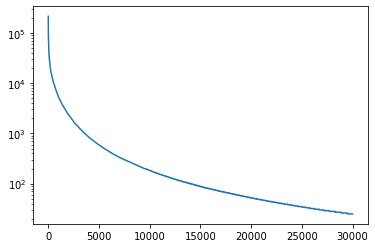

In [15]:
import matplotlib.pyplot as plt
df_freq['frequency'].plot()
plt.yscale('log')

In [16]:
df_sample = df.sample(n=20_000, replace=False, random_state=68)

In [17]:
df.to_csv(r'../data/Data_clean_processed.csv', header=True, index=False)
df_sample.to_csv(r'../data/Data_clean_processed_sample.csv', header=True, index=False)
df_freq.to_csv('../data/clean_vocab.csv', header=True, index=False)

In [18]:
data_clean = {'df_clean': df, 'df_clean_sample': df_sample, 'clean_vocab': df_freq}

In [22]:
import pickle as pkl

with open('../data/data_clean_processed.pkl', 'wb') as handle:
    pkl.dump(data_clean, handle, protocol=pkl.HIGHEST_PROTOCOL)